In [11]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import plotly.graph_objects as plt_g

# Part 3: Affine Structure from Motion

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


In [7]:
data = loadmat('data/tracks.mat')

In [15]:
def positiveDef(M):
  M = (M + M.T) * 0.5
  k = 0
  I = np.eye(M.shape[0])
  while True:
      try:
          _ = np.linalg.cholesky(M)
          break
      except np.linalg.LinAlgError:
          k += 1
          _, v = np.linalg.eig(M)
          min_eig = v.min()
          M += (-min_eig * k * k + np.spacing(min_eig)) * I
  return M

def plotShape(S):
  x = S[0,:]
  y = S[1,:]
  z = S[2,:]
  fig = plt_g.Figure(data=[plt_g.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='red'))])
  fig.show()

  fig = plt.figure(figsize=(18.5, 6))
  fig.suptitle('Reconstructed image')
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.scatter(x, y, z, color='red', lw=1)
  ax1.view_init(-90, 0)
  ax2 = fig.add_subplot(132, projection='3d')
  ax2.scatter(x, y, z, color='red', lw=1)
  ax2.view_init(90, 45)
  ax3 = fig.add_subplot(133, projection='3d')
  ax3.scatter(x, y, z, color='red', lw=1)
  ax3.view_init(0, 180)
  plt.savefig('results/structure.png')
  plt.show()

def plotCameraMotion(M):

  camera_positions = np.zeros((M.shape[0] // 2, M.shape[1]))

  # Normalizing the position vector
  M_mean = np.mean(M, axis=0)
  for i in range(M.shape[1]):
    M[:, i] = M[:, i] / M_mean[i]

  # Finding the cross-product
  for i in range(camera_positions.shape[0]):
    a_k = np.cross(M[(i *2), :], M[(i * 2) + 1, :])
    camera_positions[i, :] = np.divide(a_k, np.linalg.norm(a_k)) 
  
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
  fig.suptitle('Camera motion')
  ax1.plot(camera_positions[:, 0])
  ax2.plot(camera_positions[:, 1])
  ax3.plot(camera_positions[:, 2])
  plt.savefig('results/motion.png')
  plt.show()



In [16]:
def affineSFM(track_x, track_y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  nan_idx = []
  for i in range(track_x.shape[1]):
    for j in range(track_x.shape[0]):
      if np.isnan(track_x[j,i]) or np.isnan(track_y[j,i]):
        if not j in nan_idx:
          nan_idx.append(j)

  track_x = np.delete(track_x, nan_idx, 0)
  track_y = np.delete(track_y, nan_idx, 0)

  m = track_x.shape[1]
  n = track_x.shape[0]

  mean_x = track_x.mean(axis = 0, keepdims = True)
  track_x = np.subtract(track_x,mean_x)

  mean_y = track_y.mean(axis = 0, keepdims = True)
  track_y = np.subtract(track_y,mean_y)

  D = []
  for i in range(m):
    D.append(track_x[:,i])
    D.append(track_y[:,i])
  D = np.array(D).reshape(2*m,n)


  Ud, Sd, Vd = np.linalg.svd(D)

  U3 = Ud[:,0:3]
  W3 = np.diag(Sd[:3])
  V3 = Vd.T[:, :3]


  M = np.dot(U3, np.sqrt(W3))
  S = np.dot(np.sqrt(W3), V3.T)

  K = np.array([1,1,0])
  l = []
  for i in range(m):
    
    a1 = np.array(M[2*i]).reshape((3,1))
    a2 = np.array(M[2*i+1]).reshape((1,3))
    temp = np.dot(a1,a2)
    temp = positiveDef(temp)
    temp = temp.reshape(1,9)
    l.append(temp)

  l = np.array(l).reshape((-1,9))

  _, _, d = np.linalg.svd(l)
  L = d.T[:,-1]
  L = L.reshape(3,3)
  L = positiveDef(L)

  C = np.linalg.cholesky(L)

  M = np.dot(M,C)
  S = np.dot(np.linalg.inv(C),S)

  return M, S

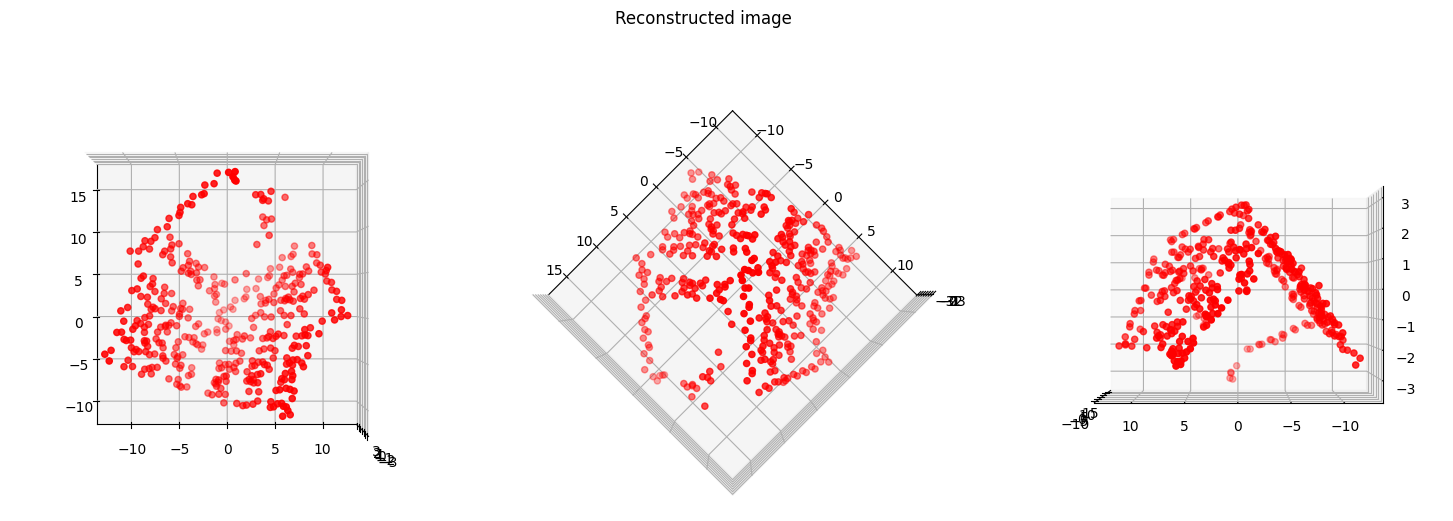

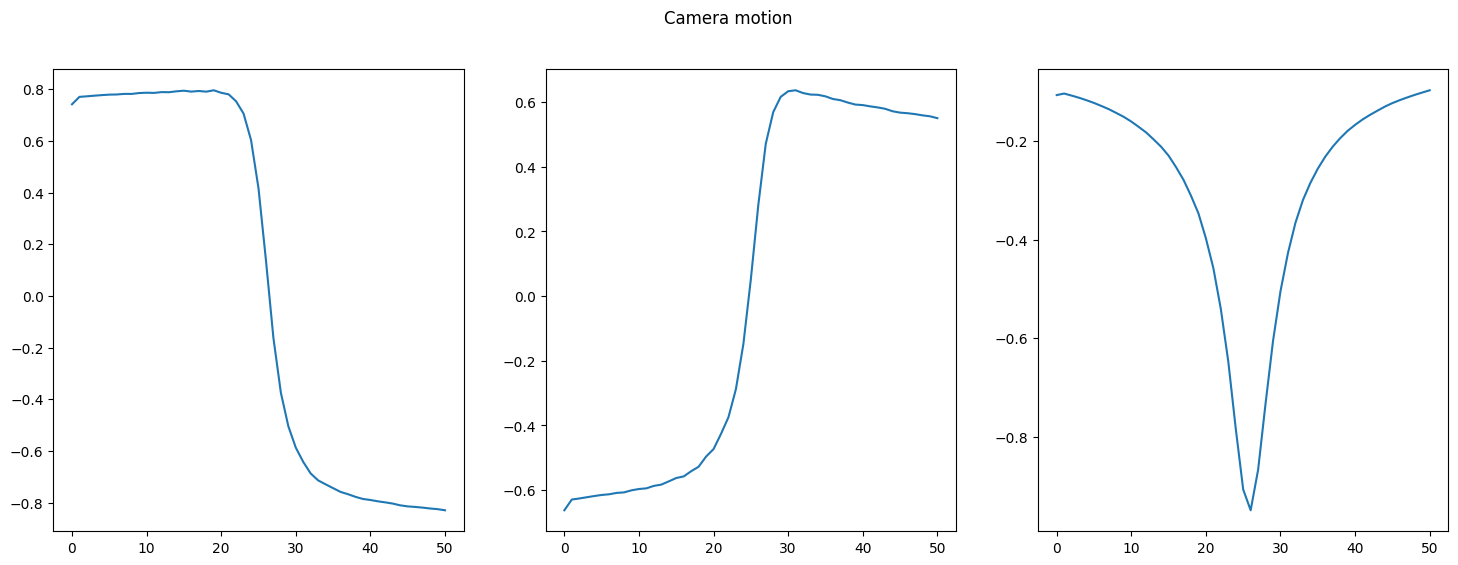

In [17]:
track_x = data['track_x']
track_y = data['track_y']
M, S = affineSFM(track_x,track_y)
plotShape(S)
plotCameraMotion(M)
